In [4]:
import torch

import triton
import triton.language as tl
from triton.runtime import driver

In [5]:
DEVICE = torch.device(f'cuda:{torch.cuda.current_device()}')

In [6]:
DEVICE

device(type='cuda', index=0)

### Autotune Configs
We sample different values of `BLOCK_SIZE_M`, `BLOCK_SIZE_N`, `BLOCK_SIZE_K`, `GROUP_SIZE_M` and `num_stages` and figure out the best combination that gives the best performance for the hardware

In [7]:
def get_cuda_autotune_config():
    return [
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages=3,
                      num_warps=8),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=5,
                      num_warps=2),
        triton.Config({'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=5,
                      num_warps=2),
        # Good config for fp8 inputs.
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=3,
                      num_warps=8),
        triton.Config({'BLOCK_SIZE_M': 256, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=3,
                      num_warps=8),
        triton.Config({'BLOCK_SIZE_M': 256, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4)
    ]

In [15]:
# `triton.jit`'ed functions can be auto-tuned by using the `triton.autotune` decorator, which consumes:
#   - A list of `triton.Config` objects that define different configurations of
#       meta-parameters (e.g., `BLOCK_SIZE_M`) and compilation options (e.g., `num_warps`) to try
#   - An auto-tuning *key* whose change in values will trigger evaluation of all the
#       provided configs
@triton.autotune(
    configs=get_cuda_autotune_config(),
    key=['M', 'N', 'K'],
)
@triton.jit
def matmul_kernel(a_ptr: torch.Tensor, b_ptr: torch.Tensor, c_ptr: torch.Tensor,
                  M: int, N: int, K: int, stride_am: int, 
                  stride_ak: int, stride_bk: int, stride_bn: int,
                  stride_cm: int, stride_cn: int,
                  BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr,
                  BLOCK_SIZE_K: tl.constexpr, GROUP_SIZE_M: tl.constexpr,
                  ACTIVATION: tl.constexpr):
    """Compute C = A x B
    Args:
        a_ptr: A torch Tensor of shape: M x K
        b_ptr: A torch Tensor of shape: K x N
        c_ptr: A torch Tensor of shape: M x N 
            This is where the output will be stored.
        M: Number of rows in A.
        N: Number of columns in B.
        K: Number of columns in A and rows in B.
        stride_am: int. How much to increase a_ptr by to reach the next row.
        atride_ak: int. How much to increase a_ptr by to reach next element.
        BLOCK_SIZE_M: Number of rows of A in a block.
        BLOCK_SIZE_K: Number of cols of A or rows of B in a block.
        BLOCK_SIZE_N: Number of cols of B in a block.
        GROUP_SIZE_M: Number of rows to process before moving on to the next column. 
            This promoted data-reuse. 
            GROUP_SIZE_M = 1 is row-major, maximum re-use of A but no re-use of B.
            GRPUP_SIZE_M = M is col-major, maximum reuse of Bbut no re-use of A.
            Somewhere in the middle we get optimal value for cache utilization.
            We'll use auto-tune config for this.
        ACTIVATION: activation to apply after matmul, fused operation.
    """
    
    pid = tl.program_id(0)
    num_pid_m = tl.cdiv(M, BLOCK_SIZE_M) # Number of programs to process blocks of size M
    num_pid_n = tl.cdiv(N, BLOCK_SIZE_N) # Number of programs to process blocks of size N
    # Number of programs/threads to process a group. Each group processes a tile of size: 
    # GROUP_SIZE_M (rows) × BLOCK_SIZE_N (columns)
    num_pid_in_group = GROUP_SIZE_M * num_pid_n
    # pid is the program id of the current process and 
    # each group has num_pid_in_group programs
    group_id = pid // num_pid_in_group
    first_pid_m = group_id * GROUP_SIZE_M
    # If BLOCK_SIZE_M is not divisible GROUP_SIZE_M
    group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)
    pid_m = first_pid_m + ((pid % num_pid_in_group) % group_size_m)
    pid_n = (pid % num_pid_in_group) // group_size_m
    offs_am = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)) % M
    offs_bn =  (pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)) % N
    offs_k = tl.arange(0, BLOCK_SIZE_K)
    accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)
    a_ptrs = a_ptr + offs_am[:, None] * stride_am + offs_k[None, :] * stride_ak
    b_ptrs = b_ptr + offs_k[:, None] * stride_bk + offs_bn[None, :] * stride_bn
    
    for k in range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        a = tl.load(a_ptrs, mask=offs_k[None, :] < K - k * BLOCK_SIZE_K, other=0.0)
        b = tl.load(b_ptrs, mask=offs_k[:, None] < K - k * BLOCK_SIZE_K, other=0.0)
        accumulator = tl.dot(a, b, accumulator)
        a_ptrs += BLOCK_SIZE_K * stride_ak
        b_ptrs += BLOCK_SIZE_K * stride_bk
    
    if ACTIVATION == "leaky_relu":
        accumulator = leaky_relu(accumulator)
    c = accumulator.to(tl.float16)
    
    offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    c_ptrs = c_ptr + stride_cm * offs_cm[:, None] + stride_cn * offs_cn[None, :]
    c_mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < N)
    tl.store(c_ptrs, c, mask=c_mask)
    
@triton.jit
def leaky_relu(x: torch.Tensor) -> torch.Tensor:
    return tl.where(x >= 0, x, 0.01 * x)
                  

In [16]:
def matmul(a, b, activation=""):
    # Check constraints.
    assert a.shape[1] == b.shape[0], "Incompatible dimensions"
    assert a.is_contiguous(), "Matrix A must be contiguous"
    M, K = a.shape
    K, N = b.shape
    # Allocates output.
    c = torch.empty((M, N), device=a.device, dtype=torch.float16)
    # 1D launch kernel where each block gets its own program.
    grid = lambda META: (triton.cdiv(M, META['BLOCK_SIZE_M']) * triton.cdiv(N, META['BLOCK_SIZE_N']), )
    matmul_kernel[grid](
        a, b, c,  #
        M, N, K, #
        a.stride(0), a.stride(1),  #
        b.stride(0), b.stride(1),  #
        c.stride(0), c.stride(1),  #
        ACTIVATION=activation  #
    )
    return c

In [ ]:
torch.manual_seed(0)
a = torch.randn((512, 512), device=DEVICE, dtype=torch.float16)
b = torch.randn((512, 512), device=DEVICE, dtype=torch.float16)
triton_output = matmul(a, b)
torch_output = torch.matmul(a, b)
print(f"triton_output_with_fp16_inputs={triton_output}")
print(f"torch_output_with_fp16_inputs={torch_output}")
if torch.allclose(triton_output, torch_output, atol=1e-2):
    print("✅ Triton and Torch match")
else:
    print("❌ Triton and Torch differ")

triton_output_with_fp16_inputs=tensor([[ -4.4844, -18.9844,   8.2500,  ..., -16.2344,  36.6562, -14.1406],
        [ 27.0781, -38.7188, -24.4531,  ..., -21.7031, -26.5938,  17.4688],
        [-13.3438,  14.1719,   7.6016,  ...,  -9.1172, -43.2500,   9.6406],
        ...,
        [  9.6406,   1.0146,  -9.3047,  ...,  -7.7852,  39.8438,  13.6172],
        [-28.8594,   8.2500,  16.6719,  ..., -33.7500, -33.3125,  56.2188],
        [ -3.8203,   0.7295,  18.9219,  ..., -33.4375,  -4.7852,  45.1562]],
       device='cuda:0', dtype=torch.float16)
torch_output_with_fp16_inputs=tensor([[ -4.4844, -18.9844,   8.2500,  ..., -16.2344,  36.6562, -14.1406],
        [ 27.0781, -38.7188, -24.4531,  ..., -21.7031, -26.5938,  17.4688],
        [-13.3438,  14.1719,   7.6016,  ...,  -9.1172, -43.2500,   9.6406],
        ...,
        [  9.6406,   1.0146,  -9.3047,  ...,  -7.7852,  39.8438,  13.6172],
        [-28.8594,   8.2500,  16.6719,  ..., -33.7500, -33.3125,  56.2188],
        [ -3.8203,   0.7295,  1

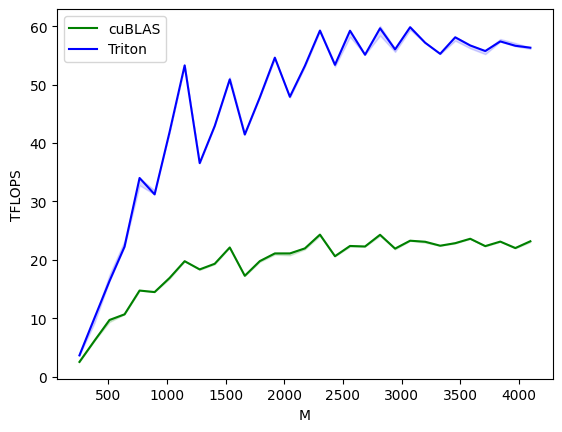

matmul-performance-fp32:
         M       N       K     cuBLAS     Triton
0    256.0   256.0   256.0   2.520615   3.640889
1    384.0   384.0   384.0   6.144000  10.053818
2    512.0   512.0   512.0   9.709037  16.384000
3    640.0   640.0   640.0  10.666666  22.260869
4    768.0   768.0   768.0  14.745600  34.028308
5    896.0   896.0   896.0  14.483794  31.220622
6   1024.0  1024.0  1024.0  16.912516  41.943041
7   1152.0  1152.0  1152.0  19.774728  53.321142
8   1280.0  1280.0  1280.0  18.367713  36.571428
9   1408.0  1408.0  1408.0  19.332539  42.927368
10  1536.0  1536.0  1536.0  22.122720  50.920059
11  1664.0  1664.0  1664.0  17.272384  41.469642
12  1792.0  1792.0  1792.0  19.787718  47.827336
13  1920.0  1920.0  1920.0  21.105344  54.640315
14  2048.0  2048.0  2048.0  21.103416  47.934905
15  2176.0  2176.0  2176.0  21.969048  53.237164
16  2304.0  2304.0  2304.0  24.325735  59.275115
17  2432.0  2432.0  2432.0  20.627360  53.411530
18  2560.0  2560.0  2560.0  22.382514  59.25

In [19]:
configs = []
ref_lib = "cuBLAS"
configs.append(
    triton.testing.Benchmark(
        x_names=["M", "N", "K"],  # Argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(2, 33)],  # Different possible values for `x_name`
        line_arg="provider",  # Argument name whose value corresponds to a different line in the plot
        # Possible values for `line_arg`
        # Don't compare to cublas for fp8 cases as torch.matmul doesn't support fp8 at the moment.
        line_vals=[ref_lib.lower(), "triton"] , # Label name for the lines
        line_names=[ref_lib, "Triton"],  # Line styles
        styles=[("green", "-"), ("blue", "-")],
        ylabel="TFLOPS",  # Label name for the y-axis
        plot_name="matmul-performance-" +
        ("fp32"),  # Name for the plot, used also as a file name for saving the plot.
         args={},
    ))


@triton.testing.perf_report(configs)
def benchmark(M, N, K, provider):
    a = torch.randn((M, K), device=DEVICE, dtype=torch.float32)
    b = torch.randn((K, N), device=DEVICE, dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    if provider == ref_lib.lower():
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.matmul(a, b), quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: matmul(a, b), quantiles=quantiles)
    perf = lambda ms: 2 * M * N * K * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)


print(benchmark.run(show_plots=True, print_data=True))